# Neural Network for Ternary Classification of Stress - Breathing Coils
- There will be three classes: S1, S2 and Rest. This is achieved by combining the S1 and S2 class into one class, Stress
- This network will aim to use just the coils extracted from the data collection.

## Architecture 
- This network has a fetaure extraction for just the coils. These layers are then combined together with a dense layer and then output

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
import heartpy as hp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import optuna
from optuna.integration import TFKerasPruningCallback
import keras

In [191]:

# Compilation Options
CLASS_WEIGHTS = True
TUNING = False

In [192]:

# Read the CSV file into a DataFrame
file_path = 'filtered_normalized_stress_data.csv'
data = pd.read_csv(file_path)

In [193]:

# Helper function to plot the signals
def plot_figure(signal, title): 
    plt.figure(figsize=(10, 5))
    plt.plot(signal)
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(146751, 4)
classification
S1      50000
Rest    48876
S2      47875
Name: count, dtype: int64
['S2' 'S1' 'Rest']


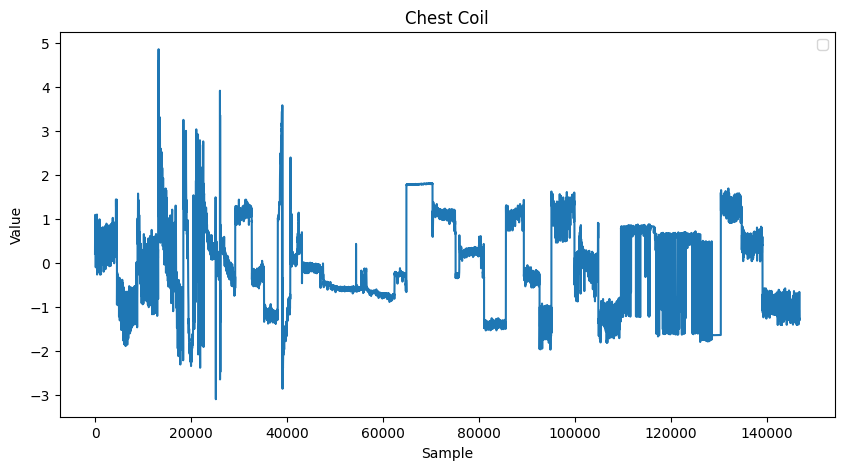

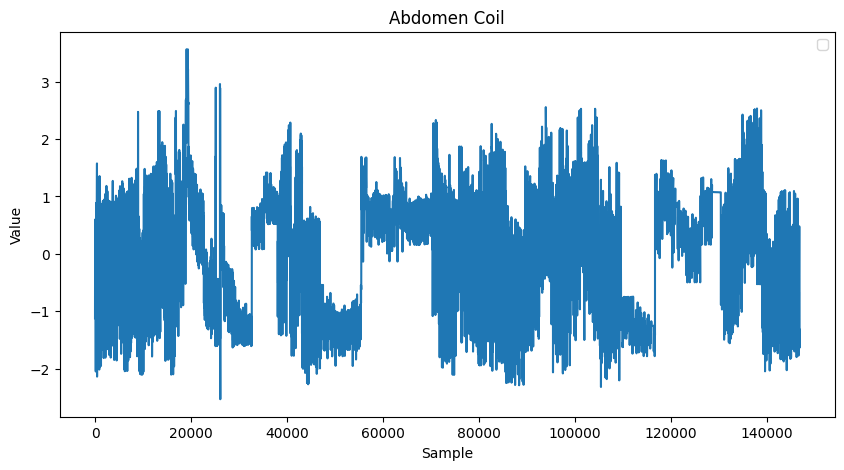

In [194]:

# Columns to extract from the dataset
columns_to_extract = ['user_id', 'classification', 'chest_coil', 'abdomen_coil']
features = ['chest_coil', 'abdomen_coil']

# Extract the specified columns
extracted_columns = data[columns_to_extract]

# Drop any rows with missing data
extracted_columns = extracted_columns.dropna()

# Convert any non numeric data to float or else drop the row
for feature in features:
    extracted_columns[feature] = pd.to_numeric(extracted_columns[feature], errors='coerce')

if extracted_columns.isnull().values.any():
    print("NaNs detected after attempting to convert non-numeric values to float. Please check the data.")
    extracted_columns = extracted_columns.dropna()

print(extracted_columns.shape)

# Ensure we are using the cleaned data for further processing
data = extracted_columns

print(data['classification'].value_counts())
print(data['classification'].unique())

# Plot the signals
plot_figure(data['chest_coil'], 'Chest Coil')
plot_figure(data['abdomen_coil'], 'Abdomen Coil')


In [195]:
# Extract features and labels
X = data[features].values
y = data['classification'].values
user_ids = data['user_id'].values

In [196]:
# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(label_encoder.classes_)

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=3)

['Rest' 'S1' 'S2']


In [197]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [198]:

# Reshape data into sequences
time_step_length = 200 
num_samples = len(X_scaled) // time_step_length

X_sequences = np.array([X_scaled[i*time_step_length:(i+1)*time_step_length] for i in range(num_samples)])
y_sequences = np.array([y[i*time_step_length] for i in range(num_samples)])
user_id_sequences = np.array([user_ids[i*time_step_length] for i in range(num_samples)])
print(user_id_sequences)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5

In [199]:
# Split the data into training and testing sets based on user_id to avoid data leakage
gkf = GroupKFold(n_splits=5)
for train_index, test_index in gkf.split(X_sequences, y_sequences, groups=user_id_sequences):
    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]
    break  # Use the first split

# Check the shape of the reshaped data
print("Train: ")
print(X_train.shape)  # Should be (num_samples, time_step_length, num_features)
print("Test: ")
print(X_test.shape)

Train: 
(572, 200, 2)
Test: 
(161, 200, 2)


In [200]:

# Compute class weights
if CLASS_WEIGHTS:
    y_integers = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
    class_weights_dict = dict(enumerate(class_weights))

In [201]:
# Function to create the CNN for each signal
def create_cnn_branch(input_shape, filters):
    input_signal = Input(shape=input_shape)
    x = Conv1D(filters, 3, activation='relu', padding='same')(input_signal)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    return input_signal, x

In [202]:
# Objective function for Optuna
def objective(trial):
    # Hyperparameters for tuning 
    filter_1 = trial.suggest_int('filter_1', 64, 256, step=8)
    filter_2 = trial.suggest_int('filter_2', 64, 256, step=8)

    filters = [filter_1, filter_2]
    print(filters)
    
    dense_units = trial.suggest_int('dense_units', 32, 128, step=8)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Create input branches for each feature
    input_shape = (time_step_length, 1)
    inputs = []
    branches = []

    for feature_idx in range(X_train.shape[2]):
        input_signal, branch = create_cnn_branch(input_shape, filters[feature_idx])
        inputs.append(input_signal)
        branches.append(branch)

    # Concatenate the branches
    concatenated = concatenate(branches)

    # Dense layers
    x = Dense(dense_units, activation='relu')(concatenated)
    x = Dropout(dropout_rate)(x)
    output = Dense(3, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, 'val_accuracy')

    # Prepare the training and validation data
    X_train_list = [X_train[:, :, i].reshape(-1, time_step_length, 1) for i in range(X_train.shape[2])]
    X_test_list = [X_test[:, :, i].reshape(-1, time_step_length, 1) for i in range(X_test.shape[2])]

    # Train the model
    if CLASS_WEIGHTS:
        history = model.fit(X_train_list, y_train, epochs=50, batch_size=32, validation_data=(X_test_list, y_test),
                            class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping, pruning_callback])
    else:
        history = model.fit(X_train_list, y_train, epochs=50, batch_size=32, validation_data=(X_test_list, y_test),
                            callbacks=[lr_reduction, early_stopping, pruning_callback])
    
    # Get the best validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

In [203]:
# Define Hyperparameters
if TUNING:
   # Create an Optuna study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, timeout=3600)

    # Print the best trial
    print(f'Best trial: {study.best_trial.number}')
    print(f'Best value (validation accuracy): {study.best_trial.value}')
    print('Best hyperparameters:')
    for key, value in study.best_trial.params.items():
        print(f'    {key}: {value}')


In [204]:
if TUNING:   
 # Build the best model using tuned hyperparameters
    filter_1 = study.best_trial.params['filter_1']
    filter_2 = study.best_trial.params['filter_2']

    dense_units = study.best_trial.params['dense_units']
    dropout_rate = study.best_trial.params['dropout_rate']
    best_lr = study.best_trial.params['learning_rate']
else:   
    filter_1 = 184
    filter_2 = 144
    
    dense_units = 96
    dropout_rate = 0.6
    best_lr = 0.0022392115620966054

In [205]:
# Create the CNN model
# Create input branches for each feature
input_shape = (time_step_length, 1)
inputs = []
branches = []

filters = [filter_1, filter_2]

for feature_idx in range(X_train.shape[2]):
    input_signal, branch = create_cnn_branch(input_shape, filters[feature_idx])
    inputs.append(input_signal)
    branches.append(branch)

# Concatenate the branches
concatenated = concatenate(branches)

# Dense layers
x = Dense(dense_units, activation='relu')(concatenated)
x = Dropout(dropout_rate)(x)
output = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model with Adam optimizer and learning rate scheduler
optimizer = Adam(learning_rate=best_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

_batch_size = 64

# Prepare the training and validation data
X_train_list = [X_train[:, :, i].reshape(-1, time_step_length, 1) for i in range(X_train.shape[2])]
X_test_list = [X_test[:, :, i].reshape(-1, time_step_length, 1) for i in range(X_test.shape[2])]

if CLASS_WEIGHTS:
    # Train the model with class weights
    conv_model_history = model.fit(X_train_list, y_train, epochs=50, batch_size=_batch_size, validation_data=(X_test_list, y_test),
                        class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping])
else:
    # Train the model without class weights 
    conv_model_history = model.fit(X_train_list, y_train, epochs=50, batch_size=_batch_size, validation_data=(X_test_list, y_test),
                    callbacks=[lr_reduction, early_stopping])


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.6069 - loss: 16.5530 - val_accuracy: 0.3292 - val_loss: 2.4613 - learning_rate: 0.0022
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6965 - loss: 9.6297 - val_accuracy: 0.1491 - val_loss: 3.1908 - learning_rate: 0.0022
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6810 - loss: 5.3606 - val_accuracy: 0.2981 - val_loss: 1.7024 - learning_rate: 0.0022
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7392 - loss: 2.2638 - val_accuracy: 0.2857 - val_loss: 1.1542 - learning_rate: 0.0022
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7769 - loss: 1.0732 - val_accuracy: 0.4969 - val_loss: 1.0560 - learning_rate: 0.0022
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8365 - loss: 0.7201 - val_accuracy: 0.3665 - val_loss: 1.1637 - learning_rate: 0.0022
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8248 - loss: 0.5294 - val_accuracy:

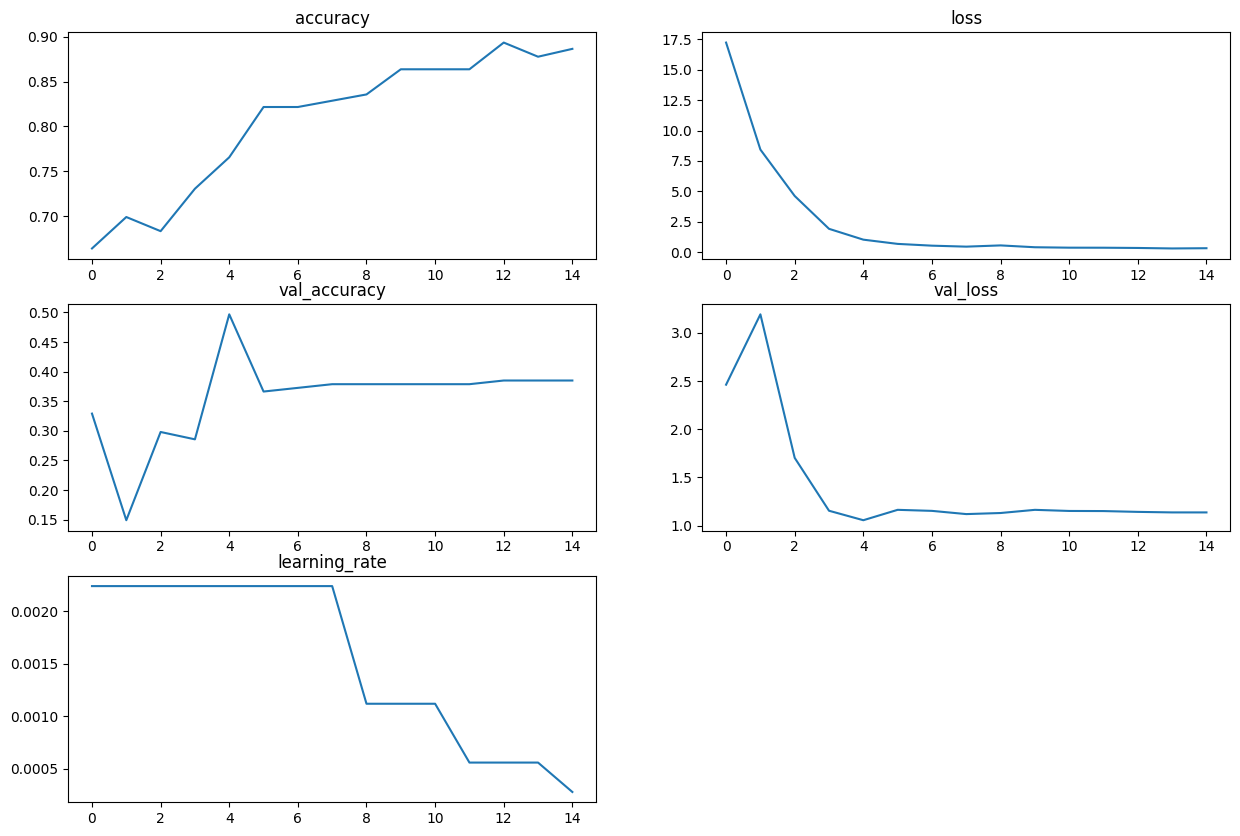

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4076 - loss: 1.0798
Test Accuracy: 0.4968944191932678


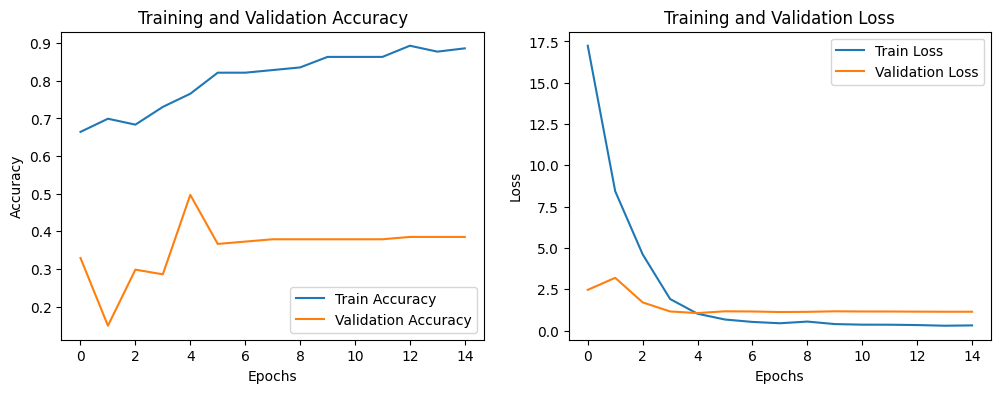

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


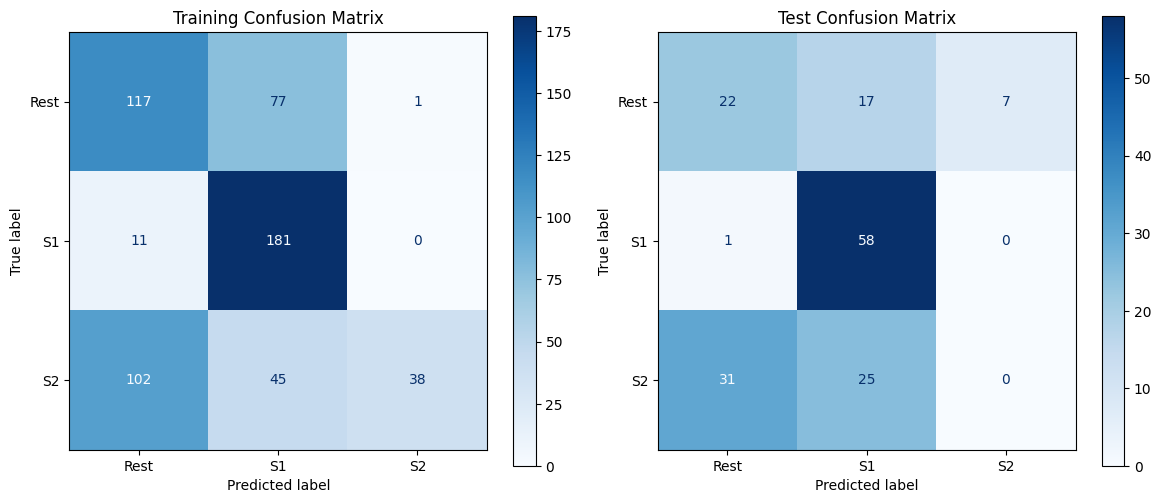

In [206]:
# Plot training history metrics
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()
    
plot_history_metrics(conv_model_history)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_list, y_test)
print("Test Accuracy:", accuracy)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(conv_model_history.history['accuracy'], label='Train Accuracy')
plt.plot(conv_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(conv_model_history.history['loss'], label='Train Loss')
plt.plot(conv_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Evaluate the model on training data to get training predictions
y_train_pred = model.predict(X_train_list)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)

# Evaluate the model on test data to get test predictions
y_test_pred = model.predict(X_test_list)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix for training data
train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
train_cmd = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=label_encoder.classes_)

# Confusion matrix for test data
test_cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
test_cmd = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_cmd.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Training Confusion Matrix')

plt.subplot(1, 2, 2)
test_cmd.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()